In [178]:
import string
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn import svm
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import json
from sklearn.metrics import accuracy_score

In [17]:
notes = pd.read_csv('notes-00000.tsv', sep='\t')
ratings = pd.read_csv('ratings-00000.tsv', sep='\t')
tweets = pd.read_csv('tweet_text2021.csv')
train = pd.read_csv('train_split_v1.csv')
test = pd.read_csv("test_split_v1.csv")

In [11]:
train.columns

Index(['noteId', 'participantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary'],
      dtype='object')

In [83]:
train_with_tweets = train.set_index("tweetId").join(tweets.set_index("id"))
train_with_tweets = ratings.set_index("noteId").join(train_with_tweets.set_index("noteId"),lsuffix='_rating', rsuffix='_note')
print(train_with_tweets.columns)
train_with_tweets = train_with_tweets[["text", "summary", "helpfulnessLevel"]]
train_with_tweets = train_with_tweets.dropna(subset=["helpfulnessLevel"])
train_with_tweets = train_with_tweets[train_with_tweets["helpfulnessLevel"] != "SOMEWHAT_HELPFUL"]
train_with_tweets.helpfulnessLevel.replace(('HELPFUL', 'NOT_HELPFUL'), (1, 0), inplace=True)
train_with_tweets = train_with_tweets.dropna()
train_with_tweets = train_with_tweets.drop_duplicates()

test_with_tweets = test.set_index("tweetId").join(tweets.set_index("id"))
test_with_tweets = ratings.set_index("noteId").join(test_with_tweets.set_index("noteId"),lsuffix='_rating', rsuffix='_note')
test_with_tweets = test_with_tweets[["text", "summary", "helpfulnessLevel"]]
test_with_tweets = test_with_tweets.dropna(subset=["helpfulnessLevel"])
test_with_tweets = test_with_tweets[test_with_tweets["helpfulnessLevel"] != "SOMEWHAT_HELPFUL"]
test_with_tweets.helpfulnessLevel.replace(('HELPFUL', 'NOT_HELPFUL'), (1, 0), inplace=True)
test_with_tweets = test_with_tweets.dropna()
test_with_tweets = test_with_tweets.drop_duplicates()

cols = ['summary', 'text']
train_with_tweets['combined'] = train_with_tweets[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
test_with_tweets['combined'] = test_with_tweets[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
train_with_tweets.columns

Index(['participantId_rating', 'createdAtMillis_rating', 'version', 'agree',
       'disagree', 'helpful', 'notHelpful', 'helpfulnessLevel', 'helpfulOther',
       'helpfulInformative', 'helpfulClear', 'helpfulEmpathetic',
       'helpfulGoodSources', 'helpfulUniqueContext', 'helpfulAddressesClaim',
       'helpfulImportantContext', 'notHelpfulOther', 'notHelpfulIncorrect',
       'notHelpfulSourcesMissingOrUnreliable',
       'notHelpfulOpinionSpeculationOrBias', 'notHelpfulMissingKeyPoints',
       'notHelpfulOutdated', 'notHelpfulHardToUnderstand',
       'notHelpfulArgumentativeOrInflammatory', 'notHelpfulOffTopic',
       'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulIrrelevantSources',
       'participantId_note', 'createdAtMillis_note', 'classification',
       'believable', 'harmful', 'validationDifficulty', 'misleadingOther',
       'misleadingFactualError', 'misleadingManipulatedMedia',
       'misleadingOutdatedInformation', 'misleadingMissingImportantContext',
       'misle

Index(['text', 'summary', 'helpfulnessLevel', 'combined'], dtype='object')

In [131]:
total = []
for item in train_with_tweets["combined"]:
    total.append(len(item.split()))

sum(total)/len(total)


54.88381845091268

In [67]:
def preprocess(df):
    # we want to lowercase and remove punctuation.
    columns = ['text','summary','combined']
    for col in columns:
        df[col] = df[col].apply(lambda x: str(x).lower().translate(str.maketrans('', '', string.punctuation)))
    return df

# Let's download pretrained word2vec

In [68]:
train_with_tweets = preprocess(train_with_tweets)
train_with_tweets.head()

,text,summary,helpfulnessLevel,combined
noteId,,,,
1354678831655735296,i love the stock market because when it goes u...,fact check true httpswwwreuterscomarticleso...,1,fact check true httpswwwreuterscomarticleso...
1354678831655735296,i love the stock market because when it goes u...,fact check true httpswwwreuterscomarticleso...,1,fact check true httpswwwreuterscomarticleso...
1354815735491518467,i love the stock market because when it goes u...,according to the 2019 federal reserve survey o...,0,according to the 2019 federal reserve survey o...
1354815735491518467,i love the stock market because when it goes u...,according to the 2019 federal reserve survey o...,0,according to the 2019 federal reserve survey o...
1354841703400820745,amateur investors perhaps propelled by a mix o...,this story misrepresents the gme short squeeze...,1,this story misrepresents the gme short squeeze...


In [20]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

corpus = api.load('text8')
model = Word2Vec(corpus)
print(model.wv.most_similar('tree'))

[==================================================] 100.0% 31.6/31.6MB downloaded
[('trees', 0.7047148942947388), ('leaf', 0.6872522234916687), ('bark', 0.6528381109237671), ('bird', 0.6081185936927795), ('fruit', 0.6027373671531677), ('beetle', 0.5982184410095215), ('flower', 0.595430314540863), ('cactus', 0.5669288635253906), ('lizards', 0.5596849322319031), ('nest', 0.5566791296005249)]


In [119]:
model.vector_size

100

# Let's try a simple average and sum

In [120]:
def add_average_and_sum(model, df, col):
    averages = []
    w2v_sum = []
    for index, sentence in df[col].items():
        embeddings = []
        for word in sentence.lower().split(' '):
            if word in model.wv:
                embeddings.append(model.wv[word])
        if len(embeddings):
            averages.append(np.mean(embeddings,axis=0))
            w2v_sum.append(np.sum(embeddings,axis=0))
        else:
            averages.append(np.array([0]*model.vector_size))
            w2v_sum.append(np.array([0]*model.vector_size))
    df[f"{col}_sum"] = w2v_sum
    df[f"{col}_average"] = averages
    return df



# Create sequence with word vectors

In [149]:
def add_sequence(model, df, col, max_length = 100):
    all_sequences = []
    for index, sentence in df[col].items():
        embeddings = []
        for word in sentence.lower().split(' '):
            if word in model.wv:
                embeddings.append(model.wv[word])
        if len(embeddings) > max_length:
            embeddings = embeddings[:max_length]
        else:
            embeddings += [[0]*model.vector_size]*(max_length - len(embeddings))
        all_sequences.append(embeddings)
    df[f"{col}_embeddings"] = all_sequences
    return df

In [137]:
add_sequence(model, test_with_tweets, col)

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


ValueError: Length of values (0) does not match length of index (971)

In [150]:
cols = ["combined", "text", "summary"]
for col in cols:
    test_with_tweets = add_average_and_sum(model, test_with_tweets, col)
    test_with_tweets = add_sequence(model, test_with_tweets, col)
    
    train_with_tweets = add_average_and_sum(model, train_with_tweets, col)
    train_with_tweets = add_sequence(model, train_with_tweets, col)

train_with_tweets.head()

,text,summary,helpfulnessLevel,combined,combined_sum,combined_average,text_sum,text_average,summary_sum,summary_average,combined_embeddings,text_embeddings,summary_embeddings
noteId,,,,,,,,,,,,,
1354678831655735296,I love the stock market because when it goes u...,Fact Check: True https://www.reuters.com/ar...,1,Fact Check: True https://www.reuters.com/ar...,"[22.439014, -11.924284, -11.567308, -29.77498,...","[0.60645986, -0.32227793, -0.31262997, -0.8047...","[25.55659, -10.43338, -15.346577, -25.138018, ...","[0.70990527, -0.2898161, -0.4262938, -0.698278...","[-2.526102, -2.021319, 2.6011448, -1.8843639, ...","[-1.263051, -1.0106595, 1.3005724, -0.94218194...","[[-0.85183585, -0.85141945, 0.9942026, -0.2900...","[[0.5914752, -0.53041583, -1.1781244, 2.752597...","[[-0.85183585, -0.85141945, 0.9942026, -0.2900..."
1354815735491518467,I love the stock market because when it goes u...,According to the 2019 Federal Reserve Survey o...,0,According to the 2019 Federal Reserve Survey o...,"[32.604446, -9.497178, -36.59682, -44.241413, ...","[0.54340744, -0.1582863, -0.609947, -0.7373569...","[25.55659, -10.43338, -15.346577, -25.138018, ...","[0.70990527, -0.2898161, -0.4262938, -0.698278...","[7.639334, 0.40578666, -22.428371, -16.350786,...","[0.30557337, 0.016231466, -0.89713484, -0.6540...","[[1.484449, -1.6868186, 0.082100466, -0.032973...","[[0.5914752, -0.53041583, -1.1781244, 2.752597...","[[1.484449, -1.6868186, 0.082100466, -0.032973..."
1354841703400820745,"Amateur investors, perhaps propelled by a mix ...",This story misrepresents the GME short squeeze...,1,This story misrepresents the GME short squeeze...,"[1.4737419, 13.913326, -8.322484, -31.314371, ...","[0.033494134, 0.31621197, -0.18914737, -0.7116...","[-0.11284296, 16.527735, -15.323443, -18.58845...","[-0.0034194838, 0.5008404, -0.46434677, -0.563...","[-0.14364183, -2.3414392, 6.131403, -11.849385...","[-0.011970152, -0.19511993, 0.51095027, -0.987...","[[0.9123409, -2.0797253, 2.4430077, -3.122119,...","[[-1.7302271, 0.27296987, -0.8695542, 0.876528...","[[0.9123409, -2.0797253, 2.4430077, -3.122119,..."
1354857487397232644,Science will always guide my Administration.,"Science is too broad, and filled with too much...",0,"Science is too broad, and filled with too much...","[-20.577702, -18.744032, -0.19196546, -50.1195...","[-0.5018952, -0.4571715, -0.0046820845, -1.222...","[-1.2808864, -0.97091854, -2.5645542, -7.79296...","[-0.25617728, -0.1941837, -0.51291084, -1.5585...","[-19.995466, -19.268045, 5.2208652, -43.06363,...","[-0.540418, -0.520758, 0.14110446, -1.1638819,...","[[-0.6986509, -1.4949331, 2.8482766, -0.737019...","[[-0.6986509, -1.4949331, 2.8482766, -0.737019...","[[-0.6986509, -1.4949331, 2.8482766, -0.737019..."
1354865435288731658,.@JoeBiden will not ban fracking. That is a fact.,Joe Lied.,0,Joe Lied._.@JoeBiden will not ban fracking. Th...,"[1.1901255, -1.4191754, -0.7936796, -16.416656...","[0.17001793, -0.20273934, -0.1133828, -2.34523...","[1.6654174, -2.0076382, -1.2506299, -16.61438,...","[0.27756956, -0.33460638, -0.20843832, -2.7690...","[-0.47529212, 0.5884629, 0.45695028, 0.1977232...","[-0.47529212, 0.5884629, 0.45695028, 0.1977232...","[[-0.47529212, 0.5884629, 0.45695028, 0.197723...","[[1.0067221, 0.42485118, -3.7675457, -3.465053...","[[-0.47529212, 0.5884629, 0.45695028, 0.197723..."


In [163]:
X_train = train_with_tweets["combined_average"].tolist()
y_train = train_with_tweets["helpfulnessLevel"].tolist()

X_test = test_with_tweets["combined_average"].tolist()
y_test = test_with_tweets["helpfulnessLevel"].tolist()

In [165]:
classifiers = {"svm": svm.SVC(), 
               "MLP": MLPClassifier(random_state=1, max_iter=300), 
               "Random Forest": RandomForestClassifier(max_depth=4, random_state=0),
               "Logistic Regression": LogisticRegression()}

In [173]:
columns = ["text_sum", "text_average", "summary_sum", "summary_average", "combined_sum", "combined_average"]

y_train = train_with_tweets["helpfulnessLevel"].tolist()
y_test = test_with_tweets["helpfulnessLevel"].tolist()
results = {}

for col in columns:
    X_train = train_with_tweets[col].tolist()
    X_test = test_with_tweets[col].tolist()
    print(f"{col} ###########")
    results[col] = {}
    for clf_name in classifiers:
        clf = classifiers[clf_name]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = precision_recall_fscore_support(y_test, y_pred)[2]
        f1_neg = f1[0]
        f1_pos = f1[1]
        results[col][clf_name] = (f1_neg, f1_pos)
        print(f"\t{clf_name}: unhelpful: {f1_neg}, helpful: {f1_pos}")
    

text_sum ###########


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	svm: unhelpful: 0.0, helpful: 0.7181518151815183
	MLP: unhelpful: 0.4712514092446448, helpful: 0.5554502369668246


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Random Forest: unhelpful: 0.0, helpful: 0.7181518151815183
	Logistic Regression: unhelpful: 0.13034623217922608, helpful: 0.7057201929703653
text_average ###########
	svm: unhelpful: 0.009280742459396751, helpful: 0.7174056915949701
	MLP: unhelpful: 0.39304812834224595, helpful: 0.6197654941373535


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Random Forest: unhelpful: 0.0, helpful: 0.7181518151815183
	Logistic Regression: unhelpful: 0.13627254509018039, helpful: 0.7013167013167013
summary_sum ###########
	svm: unhelpful: 0.032036613272311214, helpful: 0.7189368770764121
	MLP: unhelpful: 0.2671232876712329, helpful: 0.6848306332842415
	Random Forest: unhelpful: 0.09442060085836909, helpful: 0.7140921409214093
	Logistic Regression: unhelpful: 0.28093645484949836, helpful: 0.6800595238095238
summary_average ###########


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	svm: unhelpful: 0.07439824945295405, helpful: 0.7151515151515152
	MLP: unhelpful: 0.474040632054176, helpful: 0.5587121212121212
	Random Forest: unhelpful: 0.09808102345415778, helpful: 0.7128309572301426
	Logistic Regression: unhelpful: 0.28135593220338984, helpful: 0.6863905325443787
combined_sum ###########


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	svm: unhelpful: 0.0, helpful: 0.7181518151815183
	MLP: unhelpful: 0.410783055198973, helpful: 0.6053310404127257


/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michael/.virtualenvs/NLP/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Random Forest: unhelpful: 0.0, helpful: 0.7181518151815183
	Logistic Regression: unhelpful: 0.19850187265917604, helpful: 0.6960227272727273
combined_average ###########
	svm: unhelpful: 0.018518518518518517, helpful: 0.719205298013245
	MLP: unhelpful: 0.39011703511053314, helpful: 0.6001705029838023
	Random Forest: unhelpful: 0.004662004662004662, helpful: 0.7177792465300727
	Logistic Regression: unhelpful: 0.25172413793103443, helpful: 0.6813509544787076


In [177]:
print(json.dumps(results, indent=4))

{
    "text_sum": {
        "svm": [
            0.0,
            0.7181518151815183
        ],
        "MLP": [
            0.4712514092446448,
            0.5554502369668246
        ],
        "Random Forest": [
            0.0,
            0.7181518151815183
        ],
        "Logistic Regression": [
            0.13034623217922608,
            0.7057201929703653
        ]
    },
    "text_average": {
        "svm": [
            0.009280742459396751,
            0.7174056915949701
        ],
        "MLP": [
            0.39304812834224595,
            0.6197654941373535
        ],
        "Random Forest": [
            0.0,
            0.7181518151815183
        ],
        "Logistic Regression": [
            0.13627254509018039,
            0.7013167013167013
        ]
    },
    "summary_sum": {
        "svm": [
            0.032036613272311214,
            0.7189368770764121
        ],
        "MLP": [
            0.2671232876712329,
            0.6848306332842415
        ],
 

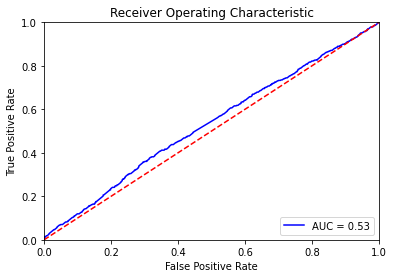

In [153]:
y_pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, [blah[1] for blah in y_pred], pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [105]:
(predictions == 1).sum()

8062